# Diffumatch: demo

We show a simple pair example of diffu_match, and observe the effects of the mask, and the results after zero-shot optimization.

First loading necessary libraries

In [1]:
import numpy as np
import os
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import potpourri3d as pp3d
import torch
from pathlib import Path
import scipy
import random
import importlib

In [2]:
from utils.geometry import compute_operators, load_operators
from utils.mesh import load_mesh 
from utils.surfaces import opt_rot_surf, Surface, centroid
from utils.utils_func import convert_dict
from utils.torch_fmap import torch_zoomout, knnsearch, extract_p2p_torch_fmap
import meshplot as mp
from utils.eval import accuracy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [17]:
import notebook_helpers as helper
import utils.meshplot as plot_helper
device = "cuda:0"
helper.device = device
cache_dir = "cache/fmaps_demo"
os.makedirs(cache_dir, exist_ok=True)

In [18]:
importlib.reload(helper)
importlib.reload(plot_helper)

<module 'utils.meshplot' from '/home/emerypierson/projects/diffumatch/utils/meshplot.py'>

Loading data. 
The first cell is voluntarily commented out, as we want to show the results on a new category in this demo. You can try example from the datasets of the paper in the cell or add new examples by modifying notebook_helpers.py

In [5]:
# demo_dataset = "SCAPE_r_ori"
# demo_dataset = "DT4D_r_ori"
# if demo_dataset == "SCAPE_r_ori":
#     cache_data = os.path.join(cache_dir, "SCAPE_ori")
#     id_1, id_2 = 52, 53
#     shape_surf, target_surf, shape_dict, target_dict, map_info = helper.load_pair(cache_data, id_1, id_2, "", "", demo_dataset)
# else:
#     cache_data = os.path.join("cache/fmaps/DT4D_ori")
#     id_1, id_2 = 0, 0
#     name_1, name_2 = "mannequin/Running047", "crypto/Standing2HMagicAttack01034"
#     shape_surf, target_surf, shape_dict, target_dict, map_info = helper.load_pair(cache_data, id_1, id_2, name_1, name_2, demo_dataset)

In [ ]:
file_source = "example/cactus.off"
shape_dict, _ = helper.load_data(file_source, os.path.join(cache_dir, "cactus.npz"), "source")
shape_surf = Surface(filename=file_source)

file_target = "example/cactus_deformed.off"
target_dict, _ = helper.load_data(file_target, os.path.join(cache_dir, "cactus_deformed.npz"), "target")
target_surf = Surface(filename=file_target)

The target mesh is on the left, uncolored. The source mesh, with coloration, on the right. We also show the two meshes overlayed.

In [7]:
cmap1 = visu_pts(shape_surf, colors)/255.
double_plot_surf(target_surf, shape_surf, None, cmap1)

0.9999999999999999
333


In [19]:
scene, _ = plot_helper.overlay_surf(shape_dict["vertices"], shape_surf.faces, target_dict["vertices"], target_surf.faces)
scene

Scene(children=[PolyMesh(data=[], default_color='tomato', triangle_indices=array([2429, 1312, 1321, ...,  750,…

Loading the diffusion model and creating the zero_shot helper class to match shapes.

In [9]:
import zero_shot
cfg = OmegaConf.load("config/matching/sds.yaml")
cfg.deepfeat_conf.fmap.lambda_ = 1
matcher = zero_shot.Matcher(cfg)

Loading network from "fmap_exps/00053-DFAUST_fmap_30abs-uncond-DiT-gpus1-batch256-fp32/network-snapshot-041216.pkl"...
Done!


Trying the mask experiment: 
- we initialize a DiffusionNet based deep functional maps network
- we then estimate a raw functional map
- we compute a mask from the raw map, using the diffusion model
- we use the mask in the map computation (same features)

In [10]:
matcher._init()
C12_pred_init, C21_pred_init, feat1, feat2, evecs_trans1, evecs_trans2 = matcher.fmap_model({"shape1": shape_dict, "shape2": target_dict}, diff_model=matcher.diffusion_model, scale=matcher.fmap_cfg.diffusion.time)

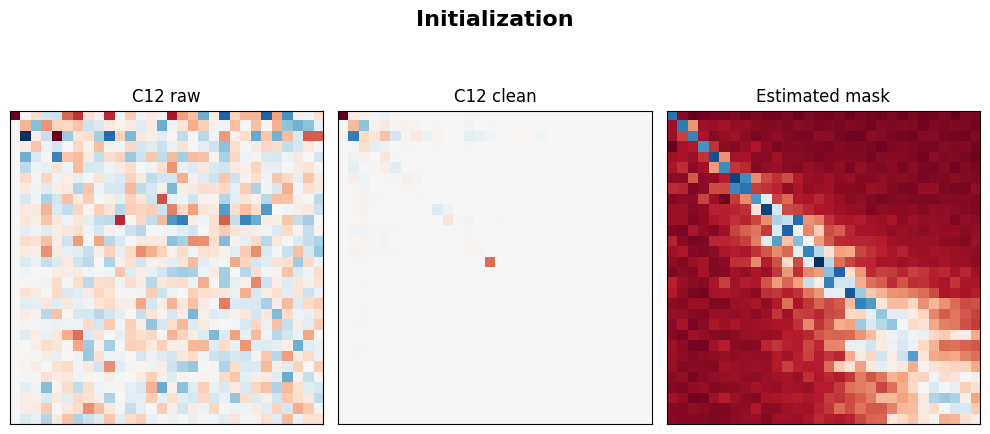

In [11]:
C12_pred, C12_obj, mask_12 = C12_pred_init
C21_pred, C21_obj, mask_21 = C21_pred_init

# C12_pred =  C12_obj = C12_pred_init
# C21_pred = C21_obj = C21_pred_init
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Show images
axs[0].imshow(C12_pred.detach().squeeze().cpu().numpy(), cmap="RdBu_r", vmax=1, vmin=-1)
axs[1].imshow(C12_obj.detach().squeeze().cpu().numpy(), cmap="RdBu_r", vmax=1, vmin=-1)
axs[2].imshow(mask_12.detach().squeeze().cpu().numpy(), cmap="RdBu_r")

# Titles under each subplot
axs[0].set_title("C12 raw", fontsize=12)
axs[1].set_title("C12 clean", fontsize=12)
axs[2].set_title("Estimated mask", fontsize=12)

# Remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

# Big title for the whole figure
fig.suptitle("Initialization", fontsize=16, weight="bold")

plt.tight_layout()
plt.show()

In [12]:
indKNN_init_obj, _ = extract_p2p_torch_fmap(C12_obj, shape_dict["evecs"], target_dict["evecs"])
cmap2 = cmap1[indKNN_init_obj]
double_plot_surf(target_surf, shape_surf,cmap2, cmap1)

The matching looks like it's doing something (look at the bottom of the cactus)! Let's now optimize with our zero-shot algorithm to improve the overall matching.

In [13]:
target_normals = torch.from_numpy(target_surf.surfel/np.linalg.norm(target_surf.surfel, axis=-1, keepdims=True)).float().to(device)
C12_new, p2p, p2p_init, _, loss_save = matcher.optimize(shape_dict, target_dict, target_normals)

Optimizing matching source target:   0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
p2p_new, _ = extract_p2p_torch_fmap(C12_new, shape_dict["evecs"], target_dict["evecs"])
cmap2 = cmap1[p2p_new]
double_plot_surf(target_surf, shape_surf,cmap2, cmap1)

The optimized map is not necessarily perfect (only 300 steps), so finally, we apply Zoomout to the computed map. Note that you can increase the number of optimization steps to have a better C12_new (paper settings is 1000 steps).

In [15]:
evecs1, evecs2 = shape_dict["evecs"], target_dict["evecs"]
evecs_2trans = evecs2.t() @ torch.diag(target_dict["mass"])
evecs_1trans = evecs1.t() @ torch.diag(shape_dict["mass"])
C12_end_zo = torch_zoomout(evecs1, evecs2, evecs_2trans, C12_new.squeeze()[:15, :15], 150)# matcher.cfg.sds_conf.zoomout)
p2p_zo, _ = extract_p2p_torch_fmap(C12_end_zo, shape_dict["evecs"], target_dict["evecs"])
cmap2 = cmap1[p2p_zo]
double_plot_surf(target_surf, shape_surf,cmap2, cmap1)

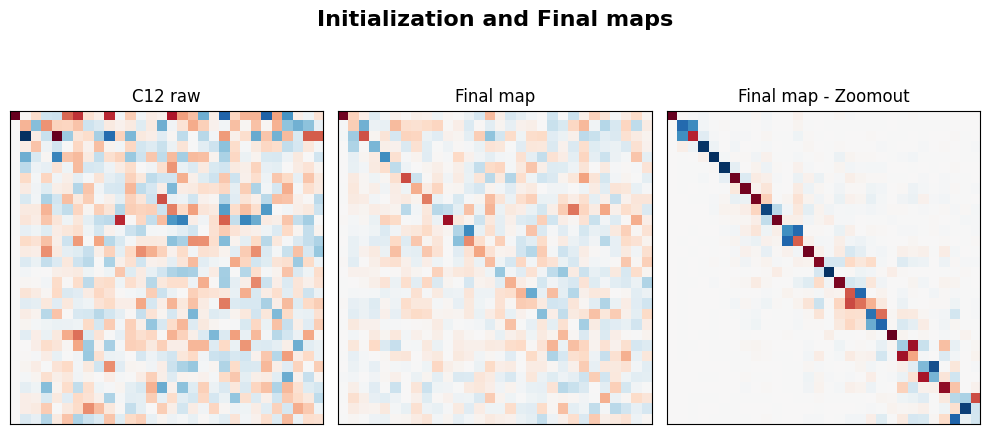

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Show images
axs[0].imshow(C12_pred.detach().squeeze().cpu().numpy(), cmap="RdBu_r", vmax=1, vmin=-1)
axs[1].imshow(C12_new.detach().squeeze().cpu().numpy(), cmap="RdBu_r", vmax=1, vmin=-1)
axs[2].imshow(C12_end_zo.detach().squeeze().cpu().numpy()[:30, :30], cmap="RdBu_r")

# Titles under each subplot
axs[0].set_title("C12 raw", fontsize=12)
axs[1].set_title("Final map", fontsize=12)
axs[2].set_title("Final map - Zoomout", fontsize=12)

# Remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

# Big title for the whole figure
fig.suptitle("Initialization and Final maps", fontsize=16, weight="bold")

plt.tight_layout()
plt.show()

Some rule of thumb for successful matching: 
- Use higher number of steps (\~1000), lower lambda (\~1e-3) and less important sds (0.1) when doing non-isometric matching. We dont want to encourage too much isometry
- Opposite, you can use a higher lambda (\~1) and sds (\~1 or higher) in the case of isometric shapes